# 1. First Things First: Understanding the Topic


## 1.1 Who is Airbnb?

Airbnb is an online market place for renting apartments, mostly for vacations. This marketplace connects people that want to rent out their privat apartments or homes and people who are searching for accommodations. It covers over 100.000 cities and 220 countries. Airbnb also provides several other offers that do not effect our work.
The datasets that are used in this analysis provide different information about Airbnb listings in Madrid.

[https://www.airbnb.com/d/howairbnbworks](https://www.airbnb.com/d/howairbnbworks)

## 1.2 Problem Definition
The prices of Airbnb listing in Madrid are not easy to assess. For a tourist it is hard to tell if the price of the Airbnb listing is in line with the value of the listing. That means if it is overpriced compared to other listings with similiar attributes or if it is a good price or even underpriced. Finding an appropriate price per night is a crucial part of Airbnb listings since the listing should neither be under- or overpriced. Underpriced offers are good for the customers (us) but are not in the interest of the host as they lower the profit margin. Overpriced offers will attract fewer guests which is also not in the interest of the host.

Our goal is to predict the price of an Airbnb lisiting in Madrid to compare this price with the "true" price of the listing on Airbnb. This analysis can be then used to classify the listings into different price-value categories. We are especially interested in finding bargains/amazing deals that clearly offer amazing value. In additon our work can used by Airbnb to propose a price for new listings that are inserted to the Airbnb website but also for hosts to see what price per night seems appropriate for their property.

To gain a better overview about the prices of the Airbnb listings, we decided to merge a Covid-19 dataset about the cases in Madrid to see whether we can also find trends in Airbnb pricing influenced by Covid.



## 1.3 Which datasets are we using?

For this notebook we are using a combination of multiple datasets from [http://insideairbnb.com/](http://insideairbnb.com/). The website "Inside Airbnb" is an investegatory website that provides monthtly scraped datasets that contain processed information about the listings on Airbnb. It has been launched by Murray Cox in 2016 and focuses on highlighting illegal rentings that are provided by Airbnb. Luckily for us they provide datasets for every major city in the world. In our case we are interested particulary in the Airbnbs in Madrid.

See also: [https://en.wikipedia.org/wiki/Inside_Airbnb](https://en.wikipedia.org/wiki/Inside_Airbnb)


We are combining the monthtly data sets from Inside Airbnb for the last two years to get the prices over time. We are also merging this dataset with the Covid-19 infections in Madrid. This data is taken from an offical website of the spanish government: [https://cnecovid.isciii.es/covid19/resources/casos_tecnica_provincia.csv](https://cnecovid.isciii.es/covid19/resources/casos_tecnica_provincia.csv)


## 1.4 Research questions

Besides our personal interest in this problem, it also opens up many research questions:

- How does the price of an Airbnb come about?
- Which characteristics of a listing play a big role in determining the price?
- Is it the location, the size of the apartment, or simply the number of people who can stay there?
- Can we predict the price of an Airbnb with sufficient accuracy?
- Is it possible to subsequently determine the price-performance ratio of a listing?

With this paper we would like to address these questions and use them as a guideline for our notebook.


# 2. Importing the necessary Libraries

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

# For Data Prep and Feature Engineering
import requests
import urllib.request
import json
from geopy.distance import distance
from bs4 import BeautifulSoup
import statistics


#3. Dataset Generation

In [2]:
# Setting this to true can take very long (>30 mins) depending on your internet connection and machine
# Downloads > 1 GB of data that will concatenated into several more usable datasets
GENERATE_DATASETS = False

## 3.1 Airbnb Datasets

The available datasets from [InsideAirbnb](http://insideairbnb.com/get-the-data.html) are snapshots taken once per month. As such a single dataset does not offer any value if we want to look at time series data. Luckily they provide archived monthly datasets for the last 3 years. We can concat those datasets to create a new dataset that allows us to look into trends over time. The code below can be used to generate the combined datasets that contains data from over 25 monthly datasets. For better execution time we work with the a copy of the combined dataset. For the sake of completeness the cell below can be run to check how we got to our combined dataset.

Out of the over 100 variables the datasets offer only a few are relevant for our analysis as such we already filter out a lot of unusable data just by selecting usable variables. Because we also want continous data record for our Airbnb listings we only use those that have a permament data record for over 2 years. This filters out a lot of the outliers before we even start with our data processing. We can assume that fake listings, listings with incorrect information, incorrectly scraped and parsed listings, etc. will not show up for over 2 years on Airbnb. We assume Airbnbs is moderated enough to prevent this.


In [3]:
if GENERATE_DATASETS:
    TARGET_URL = "http://insideairbnb.com/get-the-data.html"

    response = requests.get(TARGET_URL)

    soup = BeautifulSoup(response.text, "html.parser")

    table_madrid = soup.find(class_="madrid")

    listing_links = table_madrid.find_all("a", href=True, text="listings.csv.gz")

    # Extract links of datasets from website
    datasets = [(link.get("href"), link.get("href").split("/")[6], link.get("href").split("/")[6] + "-listings.csv") for link in listing_links]
    cleaned_datasets = ["cl-" + name for link, date, name in datasets]

    # Download all datasets
    for link, date, name in datasets:
        urllib.request.urlretrieve(link, name)

    usable_columns = {"id",
    "host_id",
    "host_listings_count",
    "host_identity_verified",
    "neighbourhood_cleansed",
    "neighbourhood_group_cleansed",
    "latitude",
    "longitude",
    "room_type",
    "accommodates",
    "bathrooms"
    "bedrooms",
    "beds",
    "price",
    "number_of_reviews",
    "review_scores_rating"
    }

    # Unzip and clean each dataset individually
    for link, date, name in datasets:
        df = pd.read_csv(name, compression='gzip')
        dfc = pd.DataFrame()
        for column in usable_columns:
            if column in df.columns:
                dfc[column] = df[column]
        dfc["date"] = date
        dfc.to_csv("cl-" + name, index=False)
    
    df_collection = [pd.read_csv(name) for name in cleaned_datasets]

    # Combine all datasets
    df_combined = pd.concat(df_collection)

    # Format to date time
    df_combined['date'] = pd.to_datetime(df_combined['date'])

    # Filter out dates out of interest
    df_combined = df_combined[df_combined["date"].isin(pd.date_range('2019-01-01', '2021-12-31'))]

    # Find occurences of ids and remove all that have below 26 entries (gurantees permanent data record)
    # TODO SIDEEEFFECT no unusuable dataentries
    df_combined = df_combined.groupby("id").filter(lambda x: len(x) > 25)

    # Format price column
    df_combined["price"] = df_combined["price"].astype('string')
    df_combined["price"] = df_combined["price"].str.replace('$', '')
    df_combined["price"] = df_combined["price"].str.replace(',', '')
    df_combined["price"] = df_combined["price"].astype('float')

    # Sort based on id then by date
    df_combined.sort_values(["id", "date"], inplace = True)

    # Save to csv for further work
    df_combined.to_csv("listings_combined.csv", index=False)

## 3.2 Covid-19 Dataset from Municipality of Madrid

Here we load in the Covid-19 dataset. It is taken from https://cnecovid.isciii.es/covid19/resources/casos_tecnica_provincia.csv and provided by the spanish government.

In [4]:
if GENERATE_DATASETS:
  df_covid_raw = pd.read_csv("https://cnecovid.isciii.es/covid19/resources/casos_tecnica_provincia.csv")

  # Select rows from Madrid
  dfc_covid_raw = df_covid_raw[df_covid_raw["provincia_iso"] == "M"]
  dfc_covid = dfc_covid_raw[["fecha", "num_casos"]]
  dfc_covid.rename(columns = {"fecha":"date", "num_casos":"cases"}, inplace = True) 
  dfc_covid["date"] = pd.to_datetime(dfc_covid["date"])
  dfc_covid.set_index("date")

  # 7 day offset for period til first symptoms
  dfc_covid.shift(14)

  # Moving average for 7 and 14 day incidence
  dfc_covid["cases_avg_7"] = dfc_covid["cases"].rolling(7).sum()
  dfc_covid["cases_avg_14"] = dfc_covid["cases"].rolling(14).sum()
  dfc_covid["cases_avg_30"] = dfc_covid["cases"].rolling(30).sum()

  dfc_covid["cases"].fillna(0, inplace=True)
  dfc_covid["cases_avg_7"].fillna(0, inplace=True)
  dfc_covid["cases_avg_14"].fillna(0, inplace=True)
  dfc_covid["cases_avg_30"].fillna(0, inplace=True)

  # Save to csv for further work
  dfc_covid.to_csv("covid_cases.csv", index=False)

## 3.3 Merge Covid-19 infections into Airbnb combined Dataset
To plot the average price of Airbnb listings together with the Covid-19 infections in Madrid, we need to merge both dataset, that were generated above.

In [5]:
if GENERATE_DATASETS:
  df_combined_with_covid = df_combined.merge(dfc_covid, how = "left")
  df_combined_with_covid["cases"].fillna(0, inplace=True)
  df_combined_with_covid["cases_avg_7"].fillna(0, inplace=True)
  df_combined_with_covid["cases_avg_14"].fillna(0, inplace=True)
  df_combined_with_covid["cases_avg_30"].fillna(0, inplace=True)

  # Save to csv for further work
  df_combined_with_covid.to_csv("listings_combined_with_covid.csv", index=False)

# 4. Pre-Processing
***Garbage in, garbage out***

Basically this means when the data we are using is somehow nonsense, for example if there are many fake overpriced listings or errors that could occure because of the scrapping, our predictions and the whole analysis will be nonsense or "garbage".

To avoid that we are going to clean up the datasets. Here we are handling missing values and outlier. In addition we are doing some feature engineering to add the feature "Distance to Center" to the dataset.

## 4.1 Loading the Data and Decoding it

### 4.1.1 Loading Datasets into Pandas

Here we are loading combined dataset that contains 26 datasets from InsideAirbnb and a dataset from the municipality of Madrid that contains the daily Covid-19 infections. That means we are loding in the datasets that were generated before.

(see chapter Dataset Generation)


In [6]:
LISTINGS_COMBINED = "listings_combined_with_covid.csv"

# read in compiled dataset and save a copy for further usage
df_listings_combined = pd.read_csv(LISTINGS_COMBINED)
dfc_listings_combined = df_listings_combined.copy()

columns_listings = ['id', 'host_id', 'host_listings_count', 'host_identity_verified', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'room_type', 'accommodates', 'bedrooms', 'beds', 'price', 'number_of_reviews', 'review_scores_rating', 'distance_to_center']
columns_listings_detailed = columns_listings +  ['date', 'cases', 'cases_avg_7', 'cases_avg_14', 'cases_avg_30']

# Reduce dfc_listings to make sure we only have relevant columns
dfc_listings_combined.drop(dfc_listings_combined.columns.difference(columns_listings_detailed), 1, inplace = True)


In [7]:
COVID_CASES = "covid_cases.csv"

df_covid_cases = pd.read_csv(COVID_CASES)
dfc_covid_cases = df_covid_cases.copy()


## 4.2 Decoding the Data
Our ML Models cannot deal with strings as an input. Therefore we have to decode every variable of the dataset that isn't a number into one. 

We did this with the following variables:



1.   neighbourhood_group_cleansed
2.   neighbourhood_cleansed
3.   room_type
4.   host_identity_verified

Also we had to deal with the date. Thus we converted the date to an useable dtype for our models.



In [8]:
# Convert all data to numerical data for dfc_listings
dfc_listings_combined['neighbourhood_group_cleansed'] = dfc_listings_combined['neighbourhood_group_cleansed'].astype("category").cat.codes
dfc_listings_combined['neighbourhood_cleansed'] = dfc_listings_combined['neighbourhood_cleansed'].astype("category").cat.codes
dfc_listings_combined['room_type'] = dfc_listings_combined['room_type'].astype("category").cat.codes
dfc_listings_combined['host_identity_verified'] = dfc_listings_combined['host_identity_verified'].astype("category").cat.codes

# Convert to date
dfc_listings_combined['date'] = pd.to_datetime(dfc_listings_combined['date'])
#-----------------------------------------------------------------------------------

# Convert to date for dfc_covid_cases
dfc_covid_cases["date"] = pd.to_datetime(dfc_covid_cases["date"])

## 4.3 Feature Engineering
We now want to engineer a new feature (variable) in our dataset. Since we are looking at an Airbnb dataset and we estimate that most of Airbnb customers are there for touristic purposes we assume the distance to the city center (and most touristic attractions) is an important factor for the airbnb prize. We can use the latitude and longitude of the airbnb listings to calculate the distance to the coordinates of the geographical city center.

In [9]:
# We are using the overpass api to access OpenStreetMap data
def queryOverpass(query):
    overpass_url = "http://overpass-api.de/api/interpreter"
    response = requests.get(overpass_url, params={'data': query})
    return response.json()['elements']

# Gets the coordinates of the city center. We assume that our search string is specific enough
def getCityCoordinates(searchString):
    overpass_query = f"""
        [out:json];
        node["name"={searchString}]["place"="city"];
        out center;
    """
    city = queryOverpass(overpass_query)[0]
    return city['lat'], city['lon']

# Gets the city boundaries (not used yet)
def getCityBoundary(searchString):
    overpass_query = f"""
        [out:json];
        rel[name={searchString}][type=boundary];
        out geom;
    """
    parts = queryOverpass(overpass_query)[-1]["members"]
    nodes = []
    for part in parts:
        node = []
        geometry = part["geometry"]
        for point in geometry:
            node.append((point["lat"], point["lon"]))
        nodes.append(node)
    #nodes = [[(point["lat"], point["lon"]) for point in part["geometry"]] for part in parts]
    return nodes

# Uses geopy to calculate the distance between two points defined by their coordinates (in m)
def getDistance(fromPoint, toPoint):
    return distance(fromPoint, toPoint).m

coordinatesMadrid = getCityCoordinates("Madrid")

dfc_listings_combined["distance_to_center"] = dfc_listings_combined.apply(lambda row: getDistance(coordinatesMadrid, (row["latitude"], row["longitude"])), axis=1)

print(dfc_listings_combined["distance_to_center"].unique())

[4915.90125896 4915.38505533 5039.20020931 ... 3810.53087065 3810.29465349
 3959.71645793]


## 4.4 Cleaning the Data

### 4.4.1 Cleaning the dfc_listings_combined Dataset


Here we want to remove unneccesary variables (columns). Since we have the host_id we do not need the name. Also we will drop the date of the last review because we will not use it in our analysis.

In [10]:
dfc_listings_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193622 entries, 0 to 193621
Data columns (total 20 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   beds                          193502 non-null  float64       
 1   id                            193622 non-null  int64         
 2   latitude                      193622 non-null  float64       
 3   host_listings_count           193488 non-null  float64       
 4   host_identity_verified        193622 non-null  int8          
 5   neighbourhood_group_cleansed  193622 non-null  int8          
 6   number_of_reviews             193622 non-null  int64         
 7   host_id                       193622 non-null  int64         
 8   neighbourhood_cleansed        193622 non-null  int8          
 9   price                         193622 non-null  float64       
 10  room_type                     193622 non-null  int8          
 11  accommodates 

#### 4.4.2.1 Missing Values
As we can see in the description of the dataset, there are very few missing values. Because the dataset is relatively big, we can just remove the rows with missing values.

In [11]:
dfc_listings_combined['beds'].fillna(dfc_listings_combined['beds'].median(), inplace=True)
dfc_listings_combined['host_listings_count'].fillna(dfc_listings_combined['host_listings_count'].median(), inplace=True)
dfc_listings_combined['review_scores_rating'].fillna(dfc_listings_combined['review_scores_rating'].median(), inplace=True)

dfc_listings_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193622 entries, 0 to 193621
Data columns (total 20 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   beds                          193622 non-null  float64       
 1   id                            193622 non-null  int64         
 2   latitude                      193622 non-null  float64       
 3   host_listings_count           193622 non-null  float64       
 4   host_identity_verified        193622 non-null  int8          
 5   neighbourhood_group_cleansed  193622 non-null  int8          
 6   number_of_reviews             193622 non-null  int64         
 7   host_id                       193622 non-null  int64         
 8   neighbourhood_cleansed        193622 non-null  int8          
 9   price                         193622 non-null  float64       
 10  room_type                     193622 non-null  int8          
 11  accommodates 

#### 4.4.2.2 Outliers
To get an overview of the numerical data, we start with boxplots:

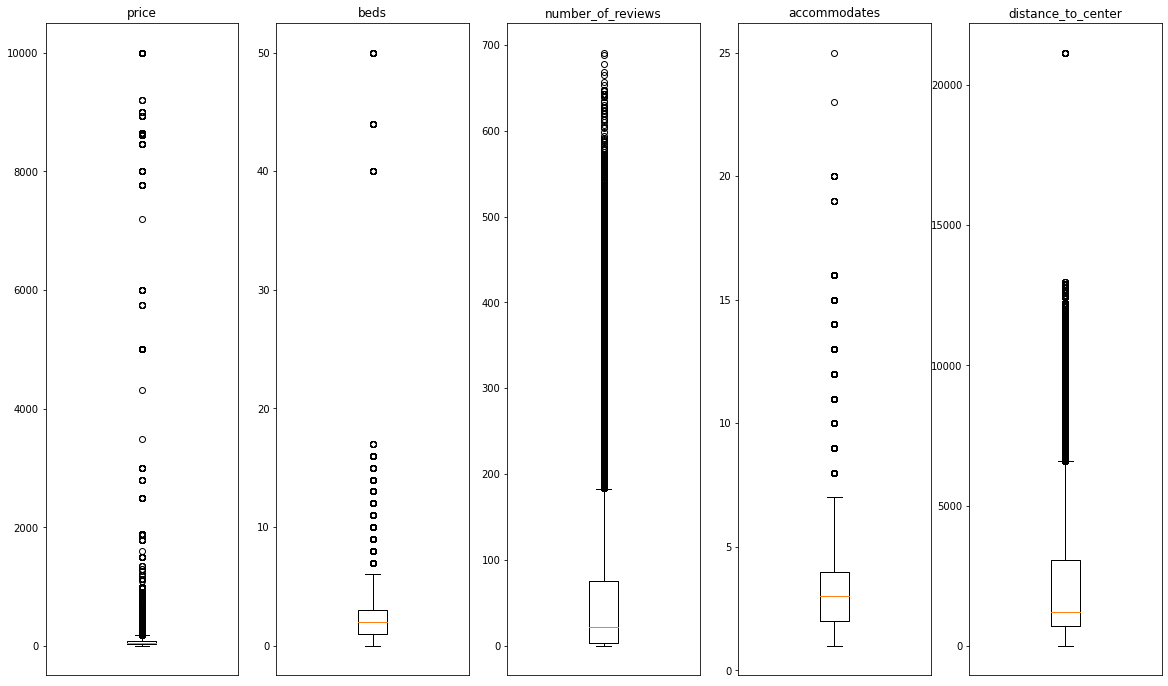

In [12]:
fig1 = plt.figure(figsize=(20, 12))
ax1 = fig1.add_subplot(1,5,1)
ax2 = fig1.add_subplot(1,5,2)
ax3 = fig1.add_subplot(1,5,3)
ax4 = fig1.add_subplot(1,5,4)
ax5 = fig1.add_subplot(1,5,5)

ax1.boxplot(dfc_listings_combined['price'])
ax1.set_title('price')
ax1.get_xaxis().set_visible(False)

ax2.boxplot(dfc_listings_combined['beds'])
ax2.set_title('beds')
ax2.get_xaxis().set_visible(False)

ax3.boxplot(dfc_listings_combined['number_of_reviews'])
ax3.set_title('number_of_reviews')
ax3.get_xaxis().set_visible(False)

ax4.boxplot(dfc_listings_combined['accommodates'])
ax4.set_title('accommodates')
ax4.get_xaxis().set_visible(False)

ax5.boxplot(dfc_listings_combined['distance_to_center'])
ax5.set_title('distance_to_center')
ax5.get_xaxis().set_visible(False)

fig1.show()

As we can see in the boxplot, the number of outliers is quite significant in regards to price. Let's clean all listings where one of the price entries is outside of an acceptable price range.

In [13]:
# Check for suggested price range
Q1_price = dfc_listings_combined['price'].quantile(0.25)
Q3_price = dfc_listings_combined['price'].quantile(0.75)
IQR_price = Q3_price - Q1_price

print("Suggested acceptable price range: From", Q1_price - 1.5 * IQR_price, "$ to", Q3_price + 1.5 * IQR_price, "$!")

Suggested acceptable price range: From -48.5 $ to 179.5 $!


We can see that we can take all entries starting from 0$ and go up to around 180$ if we take a common used range based on the quantiles. This upper limit of 180$ per night seems a bit too low because Airbnb also offers luxury homes but in our analysis we found out that most of the higher priced listings are fakes and only a small percentage are acutally real Airbnbs that are relevant for our anaylsis. (Also we are students and the high priced Airbnbs are therefore not in our price range :D)

In [14]:
# Upper limit for prices
PRICE_UPPER = Q3_price + 1.5 * IQR_price

# Remove all rows where listing has an outlier
ids_to_remove = dfc_listings_combined[dfc_listings_combined["price"] > PRICE_UPPER]["id"].unique()
for id in ids_to_remove:
  dfc_listings_combined = dfc_listings_combined[~(dfc_listings_combined["id"] == id)]

removed_ids = ids_to_remove.shape[0]
all_ids = dfc_listings_combined["id"].unique().shape[0] + removed_ids

print("Removed", removed_ids/all_ids, "of the dataframe based on the upper price limit")

Removed 0.12461393849872432 of the dataframe based on the upper price limit


We remove all the listings with 0 beds since we are only interessted in listings where we can spend a night eventhough the statistics above did not consider this as an outlier.

In [15]:
# Remove all rows where beds are 0 and associated ids
ids_to_remove = dfc_listings_combined[dfc_listings_combined["beds"] == 0 ]["id"].unique()
for id in ids_to_remove:
  dfc_listings_combined = dfc_listings_combined[~(dfc_listings_combined["id"] == id)]

removed_ids = ids_to_remove.shape[0]
all_ids = dfc_listings_combined["id"].unique().shape[0] + removed_ids

print("Removed", removed_ids/all_ids, "of the dataframe")

Removed 0.05522319374137138 of the dataframe


## 4.5 Creating a cleaned and preprocessed Dataset for our ML models
As we want to first test our models based on a single timeless snapshot of our dataset in July 2019 we need a dataset for that moment.

In [16]:
df_listings = dfc_listings_combined[dfc_listings_combined["date"].isin(pd.date_range('2019-07-01', '2019-07-31'))]
df_listings.drop(df_listings.columns.difference(columns_listings), 1, inplace = True)
dfc_listings = df_listings.copy()

# 5. Data Exploration
In this chapter we want to get an overview about our datasets. Because of all the complicated processes before namly data generating, data loading etc., it is probably to loss the orientation about all the datasets. In this chapter we are going to become specialists about our datasets, so that we will have no problems to interpret it and to learn our models!

It's an huge amount of information but we will manage that togehter!

## 5.1 Dataset Information
First we will start with a basic overview about the data. We want to know which columns we have, how many observations, what datatype these variables are, and so on and so further. 

Just have a look! :)

### 5.1.1 Overview: Dataset dfc_listings 
We will start with the dataset "dfc_listings", that was created in chapter 4.5. By the way, it was called dfc_listings, since it is our copied dataframe of all Airbnb listings.

First of all we want to know the size, the columns and the type of the dataset.
You can see that there are 6519 observations in this dataset. You can also see that there are no missing values, since we got rid of all observations with missing values in chapter 4.2.1. 

In [17]:
dfc_listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6159 entries, 32 to 193602
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   beds                          6159 non-null   float64
 1   id                            6159 non-null   int64  
 2   latitude                      6159 non-null   float64
 3   host_listings_count           6159 non-null   float64
 4   host_identity_verified        6159 non-null   int8   
 5   neighbourhood_group_cleansed  6159 non-null   int8   
 6   number_of_reviews             6159 non-null   int64  
 7   host_id                       6159 non-null   int64  
 8   neighbourhood_cleansed        6159 non-null   int8   
 9   price                         6159 non-null   float64
 10  room_type                     6159 non-null   int8   
 11  accommodates                  6159 non-null   int64  
 12  longitude                     6159 non-null   float64
 13  

Now probe into the data:
Remember we decoded the neighbourhood_group into an integer. Same has been done with the room_type, host_identity_verified and the neighbourhood.

In [18]:
dfc_listings.head()

beds     id  latitude  host_listings_count  host_identity_verified  \
32    1.0  21853  40.40341                  2.0                       1   
58    3.0  24836  40.41995                  1.0                       0   
84    1.0  26825  40.38985                  1.0                       1   
110   2.0  30320  40.41552                  3.0                       0   
136   1.0  30959  40.41111                  1.0                       0   

     neighbourhood_group_cleansed  number_of_reviews  host_id  \
32                              9                 33    83531   
58                              3                 63   101653   
84                              0                134   114340   
110                             3                167   130907   
136                             3                  8   132883   

     neighbourhood_cleansed  price  room_type  accommodates  longitude  \
32                       43   17.0          2             1   -3.74084   
58                       62  115.0          0             4   -3.69764   
84                       64   25.0          2             1   -3.69011   
110                     111   65.0          0             2   -3.70346   
136                      49   54.0          0             2   -3.70269   

     review_scores_rating  distance_to_center  
32                   92.0         3490.054000  
58                   98.0          619.859592  
84                   94.0         3193.801898  
110                  93.0          131.962428  
136                  88.0          625.851363

Secoundly a statistical description helps to give a feeling for the dataset. Here we only choose coloums for which this description makes sense.
We can see that the mean of the price of a night at a listing is 61.63 US-Dollar. 
That's good for us since we do not want to spend to much money on our trip to Madrid! Also we can see that 75% of the prices are below 80 US-Dollar and that the maximum price is 179 US-Dollar. That is not surpirsing since we got rid of all prices above 180 US-Dollar, since there were to many outliers in that price range. The minimum of 8 US-Dollar is pretty low, but we found out that these are actually prices for mostly hostels that are listed in Airbnb.

In [19]:
dfc_listings[['price','number_of_reviews', 'beds', 'distance_to_center']].describe(include='all')

price  number_of_reviews         beds  distance_to_center
count  6159.000000        6159.000000  6159.000000         6159.000000
mean     61.922715          48.414515     1.875142         2310.305210
std      33.555743          68.954971     1.501162         2297.374526
min       8.000000           0.000000     1.000000            0.563384
25%      35.000000           3.000000     1.000000          737.190218
50%      59.000000          21.000000     1.000000         1238.865794
75%      80.000000          66.000000     2.000000         3327.857651
max     179.000000         584.000000    50.000000        21159.645401

### 5.1.2 Overview: Dataset df_listings_combined

Here we have our dataset which includes all listings from Airbnb in the time from 01-2019 to 01-2021. We can see that it is a pretty big dataset. We also see that there are no missing values, since again we cleaned this dataset in chapter 4.4.

In [20]:
dfc_listings_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160134 entries, 26 to 193621
Data columns (total 20 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   beds                          160134 non-null  float64       
 1   id                            160134 non-null  int64         
 2   latitude                      160134 non-null  float64       
 3   host_listings_count           160134 non-null  float64       
 4   host_identity_verified        160134 non-null  int8          
 5   neighbourhood_group_cleansed  160134 non-null  int8          
 6   number_of_reviews             160134 non-null  int64         
 7   host_id                       160134 non-null  int64         
 8   neighbourhood_cleansed        160134 non-null  int8          
 9   price                         160134 non-null  float64       
 10  room_type                     160134 non-null  int8          
 11  accommodates

Just have a look into the data. The dataset looks familiar, since this dataset is the basis for the dataset dfc_listings, that we have seen in chapter 5.1.1.. The differences are that here we have a series of listings with the date of the scrapping and we have the Covid-19 infections as a variable.

In [21]:
dfc_listings_combined.head()

beds     id  latitude  host_listings_count  host_identity_verified  \
26   1.0  21853  40.40341                  2.0                       1   
27   1.0  21853  40.40341                  2.0                       1   
28   1.0  21853  40.40341                  2.0                       1   
29   1.0  21853  40.40341                  2.0                       1   
30   1.0  21853  40.40341                  2.0                       1   

    neighbourhood_group_cleansed  number_of_reviews  host_id  \
26                             9                 33    83531   
27                             9                 33    83531   
28                             9                 33    83531   
29                             9                 33    83531   
30                             9                 33    83531   

    neighbourhood_cleansed  price  room_type  accommodates  longitude  \
26                      43   17.0          2             1  -3.740842   
27                      43   17.0          2             1  -3.740842   
28                      43   17.0          2             1  -3.740840   
29                      43   17.0          2             1  -3.740840   
30                      43   17.0          2             1  -3.740840   

    review_scores_rating       date  cases  cases_avg_7  cases_avg_14  \
26                  92.0 2019-01-14    0.0          0.0           0.0   
27                  92.0 2019-02-06    0.0          0.0           0.0   
28                  92.0 2019-03-08    0.0          0.0           0.0   
29                  92.0 2019-04-11    0.0          0.0           0.0   
30                  92.0 2019-05-14    0.0          0.0           0.0   

    cases_avg_30  distance_to_center  
26           0.0          3490.22752  
27           0.0          3490.22752  
28           0.0          3490.05400  
29           0.0          3490.05400  
30           0.0          3490.05400

When having a look at the price we see that this dataset is pretty similar to dfc_listings. The lowest price is 8 US-Dollar and the highest price is of course 179 US-Dollar, because we got rid of all listings with a higher price than 180 US-Dollar.

In [22]:
dfc_listings_combined.describe()

beds            id       latitude  host_listings_count  \
count  160134.000000  1.601340e+05  160134.000000        160134.000000   
mean        1.877471  1.726869e+07      40.420187             6.353772   
std         1.482221  8.496662e+06       0.021323            14.345893   
min         1.000000  2.185300e+04      40.340860             0.000000   
25%         1.000000  1.117951e+07      40.409340             1.000000   
50%         1.000000  1.876572e+07      40.417400             2.000000   
75%         2.000000  2.371154e+07      40.427560             4.000000   
max        50.000000  3.155940e+07      40.562740           305.000000   

       host_identity_verified  neighbourhood_group_cleansed  \
count           160134.000000                 160134.000000   
mean                 0.484388                      5.647002   
std                  0.501330                      4.826463   
min                 -1.000000                      0.000000   
25%                  0.000000                      3.000000   
50%                  0.000000                      3.000000   
75%                  1.000000                      8.000000   
max                  1.000000                     20.000000   

       number_of_reviews       host_id  neighbourhood_cleansed          price  \
count      160134.000000  1.601340e+05           160134.000000  160134.000000   
mean           54.842326  7.119148e+07               69.232206      61.276919   
std            76.782946  6.588397e+07               33.243042      33.636889   
min             0.000000  3.162200e+04                0.000000       8.000000   
25%             3.000000  1.521527e+07               49.000000      35.000000   
50%            23.000000  4.708298e+07               62.000000      56.000000   
75%            76.000000  1.161964e+08              104.000000      80.000000   
max           691.000000  3.189839e+08              124.000000     179.000000   

           room_type   accommodates      longitude  review_scores_rating  \
count  160134.000000  160134.000000  160134.000000         160134.000000   
mean        0.781433       3.034584      -3.696415             93.771841   
std         0.994562       1.700760       0.024953              6.666448   
min         0.000000       1.000000      -3.863910             20.000000   
25%         0.000000       2.000000      -3.707520             92.000000   
50%         0.000000       2.000000      -3.701660             95.000000   
75%         2.000000       4.000000      -3.693370             97.000000   
max         3.000000      16.000000      -3.573610            100.000000   

               cases    cases_avg_7   cases_avg_14   cases_avg_30  \
count  160134.000000  160134.000000  160134.000000  160134.000000   
mean      881.461538    5892.807692   11090.153846   22787.807692   
std      1391.677805    8905.883785   16714.812311   34842.146960   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         7.500000      48.500000      71.500000      91.000000   
75%      1704.000000   12364.000000   24682.000000   38226.000000   
max      5049.000000   27723.000000   51565.000000  120797.000000   

       distance_to_center  
count       160134.000000  
mean          2309.760677  
std           2296.813391  
min              0.279633  
25%            736.365954  
50%           1240.534655  
75%           3331.006791  
max          21159.645401

### 5.1.3 Overview: Covid-19 Data

The listings were only scraped once a month this results in a low sampling rate of the data. The Covid-19 dataset is daily so this causes following **problem** when merging these two datasets:

The Listings dataset takes only one value of the Covid-19 data set each month this can be on a day with unusually many cases or unusually few cases. To prevent that, we will use a rolling function that adds the numbers of either the last 7,14 or 30 days. To access which of them is best, we will plot the actual Covid-19 (orange) data with the data the listings dataset takes from the Covid-19 data set (blue).

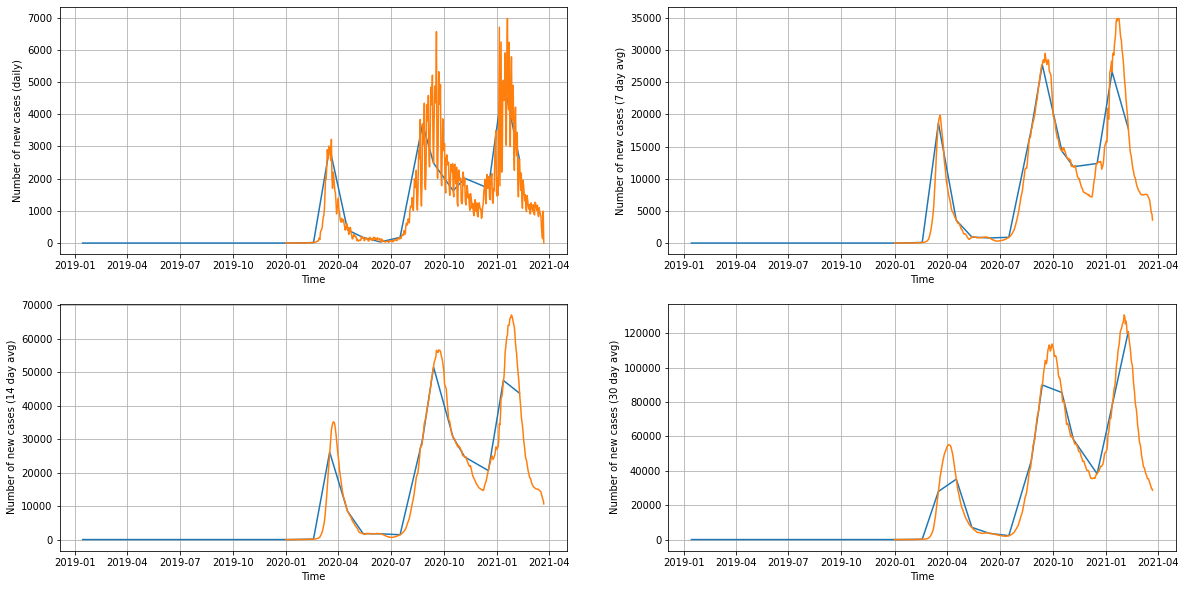

In [23]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

ax1.plot(dfc_listings_combined.drop_duplicates(subset=['date'])[['date']], dfc_listings_combined.drop_duplicates(subset=['date'])[['cases']] );
ax1.plot(dfc_covid_cases['date'], dfc_covid_cases['cases'])
#ax1.set_title('Real corona')
ax1.set_xlabel('Time')
ax1.set_ylabel('Number of new cases (daily)')
ax1.grid()

ax2.plot(dfc_listings_combined.drop_duplicates(subset=['date'])[['date']], dfc_listings_combined.drop_duplicates(subset=['date'])[['cases_avg_7']] );
ax2.plot(dfc_covid_cases['date'], dfc_covid_cases['cases_avg_7'])
#ax2.set_title('Real corona')
ax2.set_xlabel('Time')
ax2.set_ylabel('Number of new cases (7 day avg)')
ax2.grid()

ax3.plot(dfc_listings_combined.drop_duplicates(subset=['date'])[['date']], dfc_listings_combined.drop_duplicates(subset=['date'])[['cases_avg_14']] );
ax3.plot(dfc_covid_cases['date'], dfc_covid_cases['cases_avg_14'])
#ax3.set_title('Real corona')
ax3.set_xlabel('Time')
ax3.set_ylabel('Number of new cases (14 day avg)')
ax3.grid()

ax4.plot(dfc_listings_combined.drop_duplicates(subset=['date'])[['date']], dfc_listings_combined.drop_duplicates(subset=['date'])[['cases_avg_30']] );
ax4.plot(dfc_covid_cases['date'], dfc_covid_cases['cases_avg_30'])
#ax4.set_title('Real corona')
ax4.set_xlabel('Time')
ax4.set_ylabel('Number of new cases (30 day avg)')
ax4.grid()

fig.show()

Here we can see the 4 different Covid-19 case datasets (30 days average, 14 days avergage, 7 days average and daily) overlayed with the listings. 
From the 4 plots we can see that all 3 rolling averages produces reasonable data in the listings data set. To include the full covid data it makes most sense to use the 30 day rolling avg, since the sampling rate is around 30 days (1 month) too.

#### 5.1.3.1 Plotting the Covid-19 infections with the mean price of the Airbnb listings

To get a broad understanding of the price development with covid we now want to plot the covid cases with the mean price. To do so we have to group the listings by the date and then calculate the mean price for a specific point in time. 

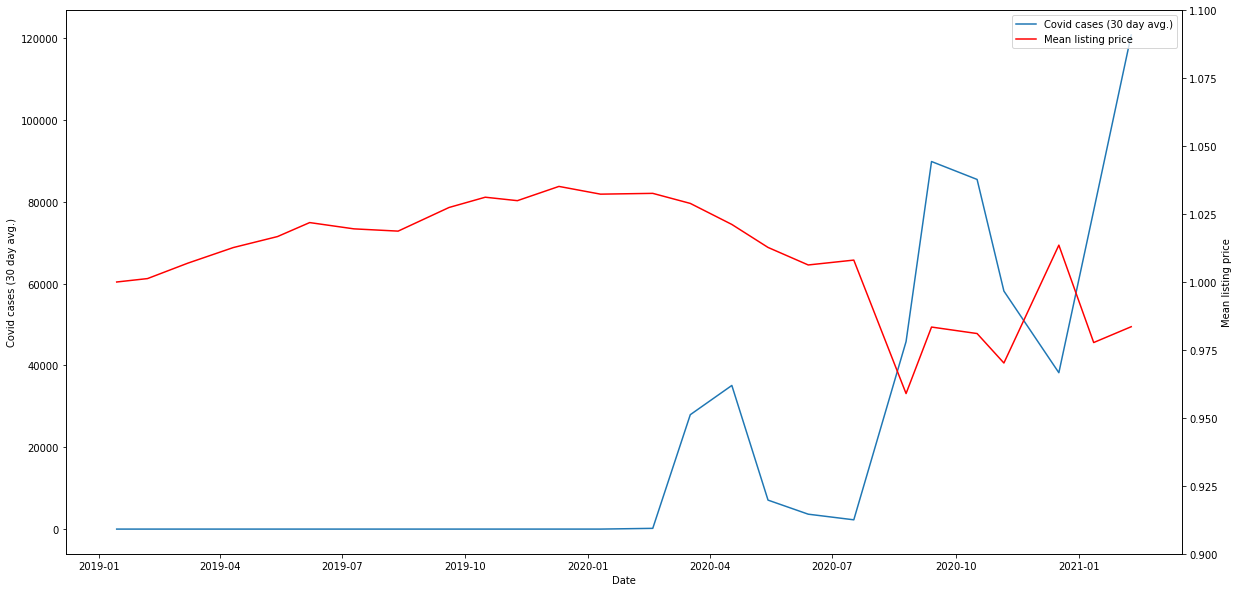

In [24]:
fig = plt.figure(figsize=(20,10))
ax1 = plt.axes()
covid, = ax1.plot(dfc_listings_combined.drop_duplicates(subset=['date'])[['date']], dfc_listings_combined.drop_duplicates(subset=['date'])[['cases_avg_30']] )
covid.set_label('Covid cases (30 day avg.)')
ax1.set_ylabel('Covid cases (30 day avg.)')
ax1.set_xlabel('Date')

ax2 = plt.twinx()
price, = ax2.plot(dfc_listings_combined.groupby("date")["price"].mean().index, dfc_listings_combined.groupby("date")["price"].mean().values/dfc_listings_combined.groupby("date")["price"].mean()[0], color = 'red')
price.set_label('Mean listing price')
ax2.set_ylabel('Mean listing price')
ax2.set_ylim([0.9, 1.1])


lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
plt.show()


The first wave of covid cases seems to have no real impact on the prices while the price drops significantly with the second wave. The prices then rise again when cases drop. When the cases rise to the third wave, the prises drop again. Here it would be interesting to have a listings dataset with a higher sampling rate. 

#### 5.1.3.2 Correlation of individual Listing Prices and Covid-19 Infections

To look deeper into the correlation of price and cases we now want to get the correlation of each listing. This is done by grouping by id.

In [25]:
# Get correlation of price and covid cases for every listing
corrs = []
for i in dfc_listings_combined['id'].unique():
    corrs.append(dfc_listings_combined[dfc_listings_combined['id']== i]['price'].corr(dfc_listings_combined[dfc_listings_combined['id']== i]['cases_avg_30']))

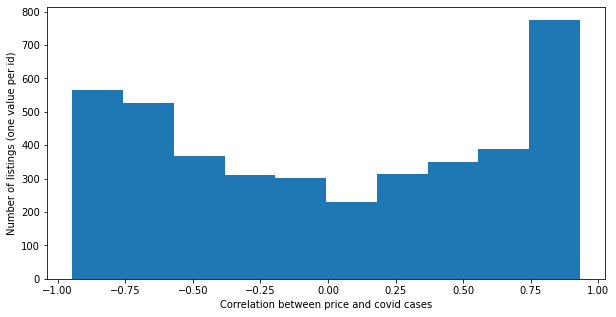

In [26]:
fig = plt.figure(figsize=(10,5))
ax1 = plt.axes()
plt.hist(pd.DataFrame(corrs), bins=10)
ax1.set_ylabel('Number of listings (one value per id)')
ax1.set_xlabel('Correlation between price and covid cases')
plt.show()

Now we can look how the correlation is distributed. Bizarrely there are many listings with a strong correlation between price and Covid-19 cases but also many listings with a strong negative correlation. There are less listings with a weak correlation. Basically this means some hosts have reduced the price of their listings and some have increase it as a response to the pandamic. This is very hard to interpret. We think the pandemic was new for everyone, so host reacted very differently. 

Note: This graph seems to make trouble in Google collab, if you run it locally it should work. Just to be safe we have attached a screenshot of how it should look like

In [27]:
mean_absolut_correlation = [abs(x) for x in corrs if str(x) != 'nan']
print('Mean absolut correlation' ,statistics.mean(mean_absolut_correlation))

mean_correlation = [x for x in corrs if str(x) != 'nan']
print('Mean correlation' ,statistics.mean(mean_correlation))

Mean absolut correlation 0.5633072135584907
Mean correlation 0.01588706884348401


The total mean of the correlation was 0.00867 which is caused by the positive and negative correlations canceling each other out. If we look at the absolute correlation we have a correlation of 0.56. While this would be high enough to work with, is the distribution hindering us to work further with the covid dataset.

## 5.2 Data Visualization
For exploring the data visual we will use histograms. Since they are suitable for a holistic view, where we can probe into the data for each attribute.

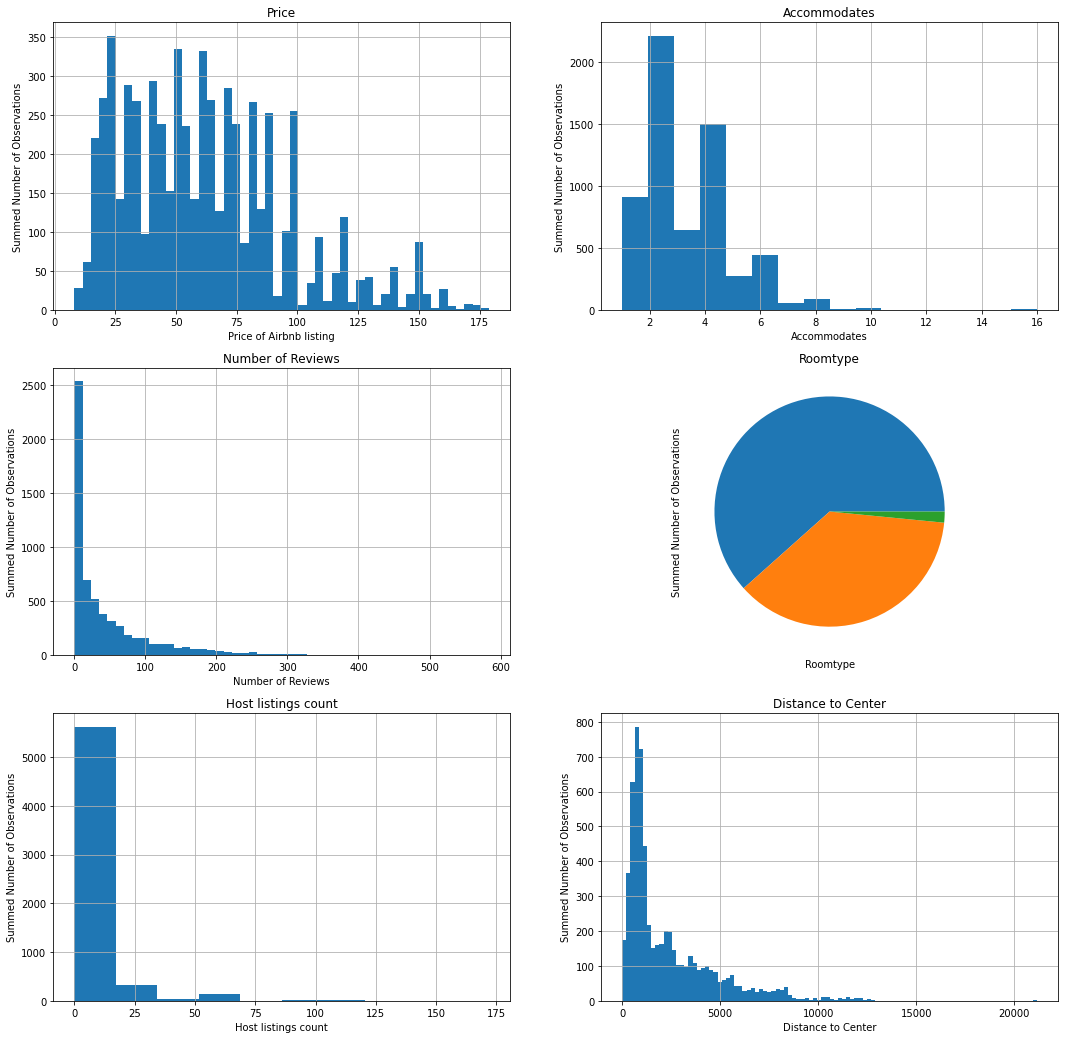

In [28]:
fig2 = plt.figure(figsize=(18, 18))
ax1 = fig2.add_subplot(3,2,1)
ax2 = fig2.add_subplot(3,2,2)
ax3 = fig2.add_subplot(3,2,3)
ax4 = fig2.add_subplot(3,2,4)
ax5 = fig2.add_subplot(3,2,5)
ax6 = fig2.add_subplot(3,2,6)

ax1.hist(dfc_listings['price'], bins=50)
ax1.set_title('Price')
ax1.set_xlabel('Price of Airbnb listing')
ax1.set_ylabel('Summed Number of Observations')
ax1.grid()

ax2.hist(dfc_listings['accommodates'], bins=16)
ax2.set_title('Accommodates')
ax2.set_xlabel('Accommodates')
ax2.set_ylabel('Summed Number of Observations')
ax2.grid()

ax3.hist(dfc_listings['number_of_reviews'], bins=50)
ax3.set_title('Number of Reviews')
ax3.set_xlabel('Number of Reviews')
ax3.set_ylabel('Summed Number of Observations')
ax3.grid()

ax4.pie(dfc_listings['room_type'].value_counts())
ax4.set_title('Roomtype')
ax4.set_xlabel('Roomtype')
ax4.set_ylabel('Summed Number of Observations')
ax4.grid()

ax5.hist(dfc_listings['host_listings_count'])
ax5.set_title('Host listings count')
ax5.set_xlabel('Host listings count')
ax5.set_ylabel('Summed Number of Observations')
ax5.grid()

ax6.hist(dfc_listings['distance_to_center'], bins=100)
ax6.set_title('Distance to Center')
ax6.set_xlabel('Distance to Center')
ax6.set_ylabel('Summed Number of Observations')
ax6.grid()

fig2.show()

We can also visualize the location for all the listings on a map.

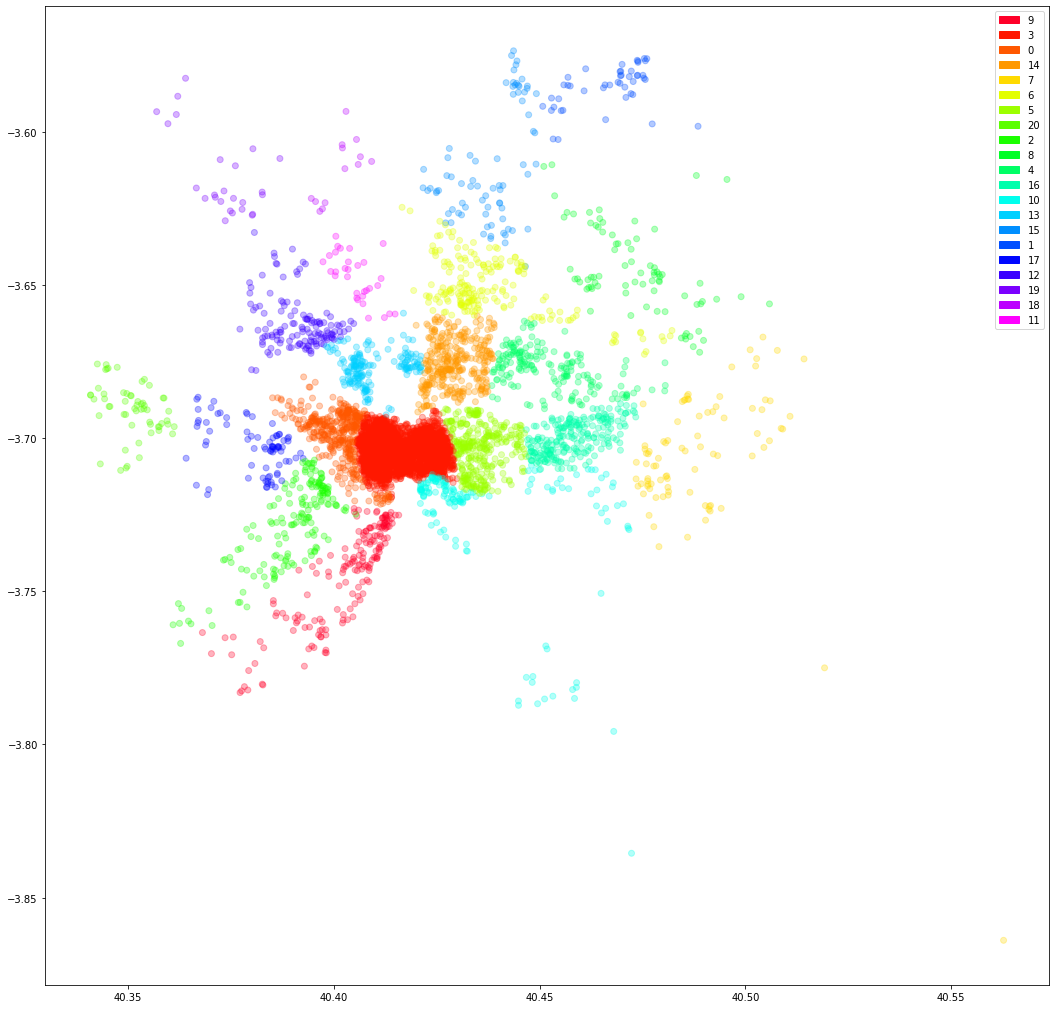

In [29]:
fig3 = plt.figure(figsize=(18, 18))
ax1 = fig3.add_subplot()

neighbourhoods = dfc_listings["neighbourhood_group_cleansed"].unique()

colors = {}
for i in range(len(neighbourhoods)):
    colors[neighbourhoods[i]] = cm.gist_rainbow(i/len(neighbourhoods))

handles = [mpatches.Patch(color=color, label=label) for label, color in colors.items()]

ax1.scatter(dfc_listings["latitude"],
            dfc_listings["longitude"],
            alpha=0.3,
            c= dfc_listings['neighbourhood_group_cleansed'].map(colors),
            cmap='gist_rainbow')
ax1.legend(handles=handles)

### 5.2.1 Correlation matrix

The correlation matrix shows the statistical correlation between two variables. It can be an indicator which variable X has the most impact of another variable Y.

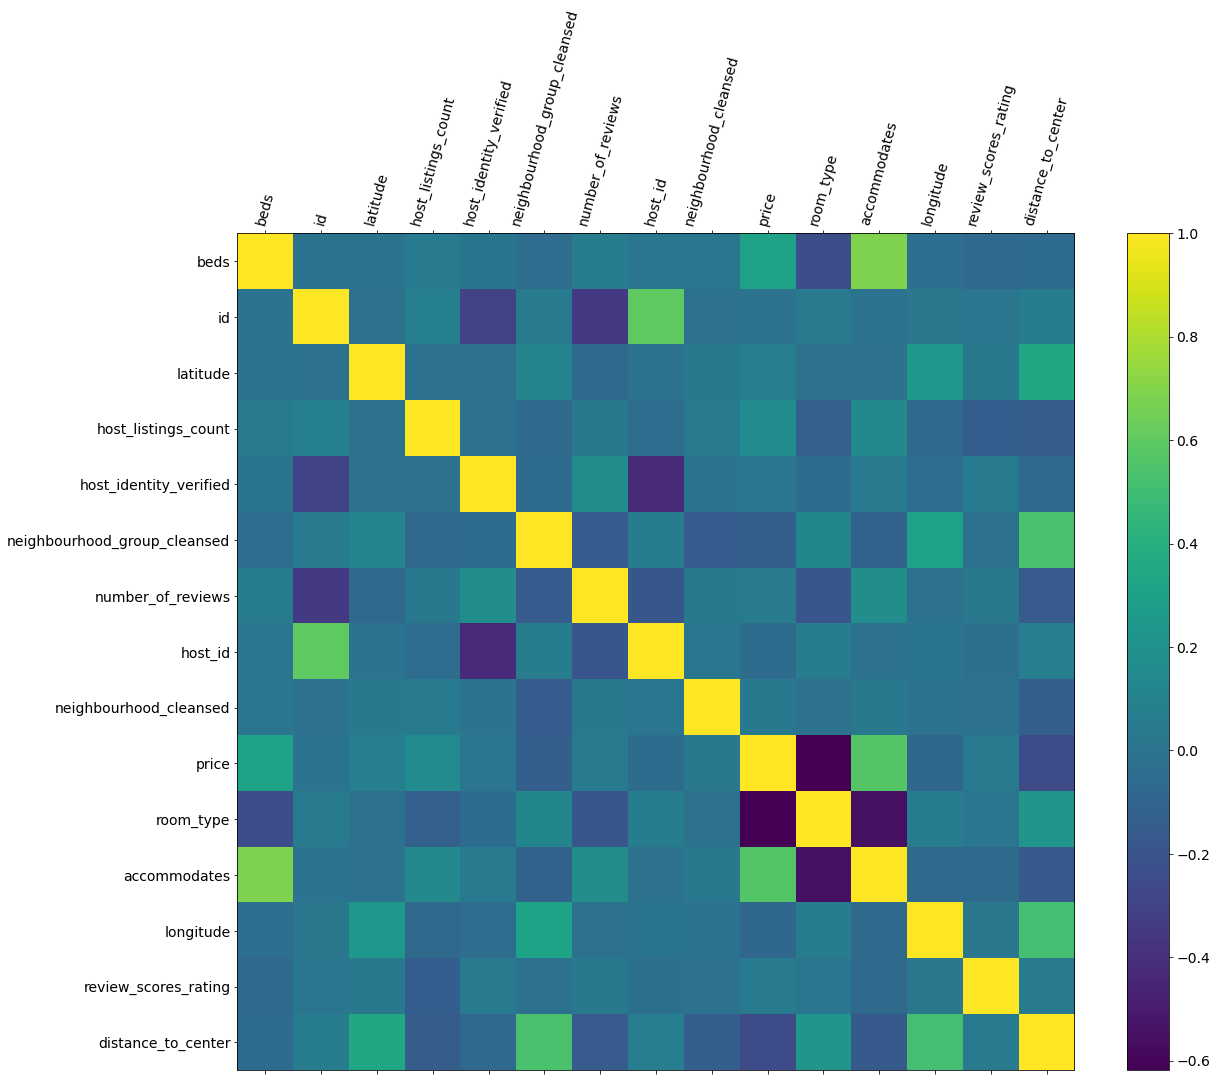

In [30]:
f = plt.figure(figsize=(19, 15))
correlationMatrix =  dfc_listings.corr()
plt.matshow(correlationMatrix, fignum=f.number)
plt.xticks(range(dfc_listings.select_dtypes(['number']).shape[1]), dfc_listings.select_dtypes(['number']).columns, fontsize=14, rotation=75)
plt.yticks(range(dfc_listings.select_dtypes(['number']).shape[1]), dfc_listings.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

We can also simply look at the table:

In [31]:
correlationMatrix.style.background_gradient(cmap='viridis').set_precision(2)

It shows that excpect of the number of reviews and reviews per month there are no strong correlations between the variables. The only other relevant correlation is between the coordinates and the distance to the center which makes sense because we extracted that feature from the coordinates.

We can say we were successful in preparing the data as we have independent variables we can use for our further modelling to predict the prices.

# 6.1 Preparing the Dataset for the Models

Since we are working with supervised ML models we need to split the dataset into two datasets for dataY we are using the target price while dataX is the remaining dataset. Splitting the dataset into X and Y is necessary for training our models. So basically we have a matrix X that labels the vector Y.

Furthermore we will split each of these datasets in a training and a test dataset. Since we have more than 16000 observations, we decided to split the data into 90% training and 10% testing.

## 6.1.1 Split Data into Train and Test Set

#### 6.1.1.1 Split Data for Non-Scaled Data

In [32]:
# Split dataset into X and Y
dataX = dfc_listings.copy().drop(['price'],axis=1)
dataY = dfc_listings['price'].copy()

# Split into train and test set
X_train, X_test, y_train, y_test = train_test_split(dataX,
dataY, test_size=0.1,
random_state=20)

#### 6.1.1.2 Split Dataset for Scaled Data
For some ML Models it is important to scale the data. For instance is the SVM with RBF as kernel assuming that all features are distributed around 0 with a variance in the same order. 
Otherwise a feature that has a variance (range) that is magnitude larger than others, it can dominate the objective funtion. 

from: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [33]:
#Rescaling the data
featuresToScale = dataX.columns
scaler = pp.StandardScaler(copy=True)
dataX_scaled = dataX.copy()
dataX_scaled.loc[:,featuresToScale] = scaler.fit_transform(dataX[featuresToScale])

#After the normalization, we need to update the splitted arrays again:
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(dataX_scaled, dataY, test_size=0.1, random_state=20)

## 6.1.2 k-fold Cross-Validation
Here we are using k-fold Cross-Validation (CV) to increase the variation of the training dataset to avoid overfitting.

When using CV the dataset is splitted into k-1 sub-training sets (fractions) and is tested over the remaining set before the model is tested on the test set. This procedure is repeated over all k folds. The accuracy of the model is the mean of the score of all test sets. 

See more:
https://scikit-learn.org/stable/modules/cross_validation.html

In [34]:
k_fold_lasso = KFold(n_splits=10, shuffle=True, random_state=50)
k_fold_svr = KFold(n_splits=5, shuffle=True, random_state=50) # less folds since compution time
k_fold_mlp = KFold(n_splits=5, shuffle=True, random_state=50) # less folds since compution time
k_fold_rf = KFold(n_splits=5, shuffle=True, random_state=50) # less folds since compution time

# 7. Train and validate Regression Models for Price Prediction
We are coming closer to our aim that is predicting the price of an Airbnb listing. 

To reach this goal we will apply 4 ML models that are commonly used:


1.   Lasso Regression
2.   Support Vector Machine Regressor aka SVR
3.   Random Forest Regressor aka RF
4.   Multi-layer Perceptron Regressor aka MLP



## 7.1 Lasso Regression
Least Absolute Shrinkage and Selection Operator Regression aka Lasso Regression is a linear regression ML model that is regularized by adding a regularization term ($\alpha$) to the cost function of the least square regression. It tries to avoid overfitting and to improve the accuracy compared to a regular linear regression model.
The cost function is given by:
	 
  \begin{equation}
  \min_{w}\frac{1}{2*n_s}* ||y-Xw||^2_2+\alpha*||w||_1
  \end{equation}

Where $\alpha$ is a constant that controls the regularization term and $||w||_1$ is the $l_1$ norm of the coefficent vector.

Read more at:
https://scikit-learn.org/stable/modules/linear_model.html#lasso

### 7.1.2 Train the Model and Print Results

In [35]:
#Setting up the parameters:
alpha=0.01 # try different values here
normalize=False 
max_iter=1000 # default = 1000
tol=0.0001 # tolerance for the optimization
random_state = 20
selection='cyclic' # "(setting to ‘random’) often leads to significantly faster convergence especially when tol is higher than 1e-4."

In [36]:
lasso_model = Lasso(alpha=alpha, normalize=normalize, max_iter=max_iter, tol=tol, random_state=random_state, selection=selection)

# Train the model
# Initialize training and cv scores as an empty list
training_scores = []
cv_scores = []

predictionsBasedOnKFolds = pd.DataFrame(data=[],index=y_train.index,columns=[0,1])
model = lasso_model

# kfold.split will generate indices to split data into training and test set (cv):
for train_index, cv_index in k_fold_lasso.split(X_train_scaled,y_train):

  #Filter the data based on the output of the CV 
  X_train_fold, X_cv_fold = X_train_scaled.iloc[train_index,:], X_train_scaled.iloc[cv_index,:]
  y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]

  #Fitting the model (Lasso) according to given data:
  model.fit(X_train_fold, y_train_fold)

  # Lets check how good is the fitting.
  # Here we are using the coefficient of determination (R^2).
  
  score_training = model.score(X_train_fold, y_train_fold)
  #Save score in the list:
  training_scores.append(score_training)

  # Calculate the performance on the CV dataset using R^2 score:
  score_CV = model.score(X_cv_fold, y_cv_fold)
  # Save score in the list:
  cv_scores.append(score_CV)

  print('Training Score: ', score_training)
  print('CV Score', score_CV)

# Eval values
score_Lasso = model.score(X_test_scaled, y_test)
mean_Lasso = statistics.mean(cv_scores)
variance_Lasso = statistics.variance(cv_scores)

print('-----------------------------------')
print('CV mean: ', mean_Lasso)
print('CV variance: ', variance_Lasso)
print('-----------------------------------')
print('Lasso Score: ', score_Lasso)
print('-----------------------------------')

Training Score:  0.4980165359046256
CV Score 0.5190548330295546
Training Score:  0.49884974517810055
CV Score 0.5135757651629516
Training Score:  0.5040597825118346
CV Score 0.43458856176228944
Training Score:  0.49499775559374914
CV Score 0.5461550003093365
Training Score:  0.5033348222430177
CV Score 0.46728007399702143
Training Score:  0.5006312571828822
CV Score 0.4970840410126628
Training Score:  0.501476928762729
CV Score 0.4885054605035115
Training Score:  0.5027853155108092
CV Score 0.47516377552473876
Training Score:  0.5004107013797243
CV Score 0.49787620905337804
Training Score:  0.5035381493206306
CV Score 0.4668460589950503
-----------------------------------
CV mean:  0.4906129779350495
CV variance:  0.0010007688539965085
-----------------------------------
Lasso Score:  0.48087454748820135
-----------------------------------


The interpretation of these results are discussed in the next chapter.

## 7.2 Support Vector Regressor
Let’s try another approach: SVM. 
SVMs were invented for classification problems but with small modifications they can be used for regression problems and even outlier detection. The SVR searches for an optimal hyperplane within a higher dimensional space, where most datapoints are close to the hyperplane. Linear approach is the fastest but performs poorer for nonlinear datasets.

See more:
https://scikit-learn.org/stable/modules/svm.html#svm-regression

Lets try SVM for our dataset!

### 7.2.1 Model Training


In [37]:
# Setting up the parameters:
kernel='linear' 
gamma='scale' #Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’. When scaled, uses 1 / (n_features * X.var()) as value of gamma.
C=1.0 # we will search for a better one in the grid search
epsilon=0.1    # Default
shrinking=True # Whether to use the shrinking heuristic. 
tol=0.00001

#Setting up the model:
svr_model = SVR(kernel= kernel, gamma=gamma, tol=tol, C=C, epsilon=epsilon, shrinking=shrinking)

In [38]:
# Train the model with CV
# Initialize training and cv scores as an empty list
training_scores = []
cv_scores = []

predictionsBasedOnKFolds = pd.DataFrame(data=[],index=y_train.index,columns=[0,1])
model = svr_model

# kfold.split will generate indices to split data into training and test set (cv):
for train_index, cv_index in k_fold_svr.split(X_train_scaled,y_train):

  #Filter the data based on the output of the CV 
  X_train_fold, X_cv_fold = X_train_scaled.iloc[train_index,:], X_train_scaled.iloc[cv_index,:]
  y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]
  #Fitting the model (Lasso) according to given data:
  model.fit(X_train_fold, y_train_fold)

  # Lets check how good is the fitting.
  # Here we are using the coefficient of determination (R^2).
  
  score_training = model.score(X_train_fold, y_train_fold)
  #Save score in the list:
  training_scores.append(score_training)

  # Calculate the performance on the CV dataset using R^2 score:
  score_CV = model.score(X_cv_fold, y_cv_fold)
  # Save score in the list:
  cv_scores.append(score_CV)

  print('Training Score: ', score_training)
  print('CV Score', score_CV)


# Eval values
score_SVR = model.score(X_test_scaled, y_test)
mean_SVR = statistics.mean(cv_scores)
variance_SVR = statistics.variance(cv_scores)

print('-----------------------------------')
print('CV mean: ', mean_SVR)
print('CV variance: ', variance_SVR)
print('-----------------------------------')
print('SVR Score: ', score_SVR)
print('-----------------------------------')

Training Score:  0.4703335528421335
CV Score 0.4924792143299195
Training Score:  0.4768172523743921
CV Score 0.47145546821197215
Training Score:  0.47850579999389264
CV Score 0.4762248637421034
Training Score:  0.4832972072243358
CV Score 0.4582175442537404
Training Score:  0.4799256657150669
CV Score 0.46706846061687635
-----------------------------------
CV mean:  0.47308911023092237
CV variance:  0.00016147239242192432
-----------------------------------
SVR Score:  0.4701852441234249
-----------------------------------


### 7.2.2 Tuning SVM Hyperparameters with Grid Search



In [39]:
kernels = ['poly','rbf']
C = np.logspace(0, 6, 10, base=2)
grid = {'kernel': kernels, 'C':C}
svr_model = SVR()

#Set up the Gridsearch with R^2 Score:
gridSearch = GridSearchCV(svr_model, grid, scoring='r2', cv=k_fold_svr, refit=True, verbose=0)
gridSearch.fit(X_train_scaled, y_train)
results = gridSearch.cv_results_

print('Best R^2:', gridSearch.best_score_)
#print('gamma value for the best case:', gridSearch.best_estimator_.gamma)
print('Best kernel:', gridSearch.best_estimator_.kernel)
print('C value for the best case:', gridSearch.best_estimator_.C)

#Saving the best parameters back to model:
svr_model = gridSearch.best_estimator_

Best R^2: 0.5583467233192511
Best kernel: rbf
C value for the best case: 64.0


Let's try the model with the new values that were found in the grid search!

In [40]:
# Setting up the parameters:
kernel=gridSearch.best_estimator_.kernel
gamma='scale' 
C=gridSearch.best_estimator_.C
epsilon=0.1    # Default
shrinking=True # Whether to use the shrinking heuristic. 
tol=0.00001

#Setting up the model:
svr_model = SVR(kernel= kernel, gamma=gamma, tol=tol, C=C, epsilon=epsilon, shrinking=shrinking)

In [41]:
# Train the model with CV
# Initialize training and cv scores as an empty list
training_scores = []
cv_scores = []

predictionsBasedOnKFolds = pd.DataFrame(data=[],index=y_train.index,columns=[0,1])
model = svr_model

# kfold.split will generate indices to split data into training and test set (cv):
for train_index, cv_index in k_fold_svr.split(X_train_scaled,y_train):

  #Filter the data based on the output of the CV 
  X_train_fold, X_cv_fold = X_train_scaled.iloc[train_index,:], X_train_scaled.iloc[cv_index,:]
  y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]
  #Fitting the model (Lasso) according to given data:
  model.fit(X_train_fold, y_train_fold)

  # Lets check how good is the fitting.
  # Here we are using the coefficient of determination (R^2).
  
  score_training = model.score(X_train_fold, y_train_fold)
  #Save score in the list:
  training_scores.append(score_training)

  # Calculate the performance on the CV dataset using R^2 score:
  score_CV = model.score(X_cv_fold, y_cv_fold)
  # Save score in the list:
  cv_scores.append(score_CV)

  print('Training Score: ', score_training)
  print('CV Score', score_CV)


# Eval values
score_SVR = model.score(X_test_scaled, y_test)
mean_SVR = statistics.mean(cv_scores)
variance_SVR = statistics.variance(cv_scores)

print('-----------------------------------')
print('CV mean: ', mean_SVR)
print('CV variance: ', variance_SVR)
print('-----------------------------------')
print('SVR Score after Grid Search: ', score_SVR)
print('-----------------------------------')

Training Score:  0.643269203908873
CV Score 0.5748937512262662
Training Score:  0.6491030914847326
CV Score 0.5778943436330186
Training Score:  0.6449679340258279
CV Score 0.5556405784112449
Training Score:  0.6484599043600021
CV Score 0.5443463665115278
Training Score:  0.6543927321825723
CV Score 0.5389582874640446
-----------------------------------
CV mean:  0.5583466654492204
CV variance:  0.000308789562097039
-----------------------------------
SVR Score after Grid Search:  0.5423785148556705
-----------------------------------


## 7.3 RandomForest Regressor
Now let’s try an ensemble learner: A random forest regressor. 
Random forests are made up of many decision trees. Here lies their strength: each of the decision trees is weak by itself but combined they usually produce good results. The same applies for the random forest regressor.
For more info visit: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

### 7.3.1 Train the Model

In [42]:
# Setting up the parameters
n_estimators = 100 # default = 100
criterion = 'mse' #criterion{“mse”, “mae”}, default=”mse”
min_samples_split = 2 #default=2
min_samples_leaf = 1 # default = 1
random_state = 50

In [43]:
rf_model = RandomForestRegressor(n_estimators=n_estimators, criterion=criterion, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=random_state)
# Train the model
# Initialize training and cv scores as an empty list
training_scores = []
cv_scores = []

predictionsBasedOnKFolds = pd.DataFrame(data=[],index=y_train.index,columns=[0,1])
model = rf_model

# kfold.split will generate indices to split data into training and test set (cv):
for train_index, cv_index in k_fold_rf.split(X_train,y_train):

  #Filter the data based on the output of the CV 
  X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
  y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]


  #Fitting the model (Lasso) according to given data:
  model.fit(X_train_fold, y_train_fold)

  # Lets check how good is the fitting.
  # Here we are using the coefficient of determination (R^2).
  
  score_training = model.score(X_train_fold, y_train_fold)
  #Save score in the list:
  training_scores.append(score_training)

  # Calculate the performance on the CV dataset using R^2 score:
  score_CV = model.score(X_cv_fold, y_cv_fold)
  # Save score in the list:
  cv_scores.append(score_CV)

  print('Training Score: ', score_training)
  print('CV Score', score_CV)

# Eval values
score_RF = model.score(X_test, y_test)
mean_RF = statistics.mean(cv_scores)
variance_RF = statistics.variance(cv_scores)

print('-----------------------------------')
print('CV mean: ', mean_RF)
print('CV variance: ', variance_RF)
print('-----------------------------------')
print('RF Score: ', score_RF)
print('-----------------------------------')

Training Score:  0.9416232424550355
CV Score 0.5895190856958943
Training Score:  0.940957403953896
CV Score 0.6075138813539858
Training Score:  0.942401517607263
CV Score 0.5635131344406088
Training Score:  0.9417395699285523
CV Score 0.5710408559050368
Training Score:  0.9417624926549792
CV Score 0.5784489964436675
-----------------------------------
CV mean:  0.5820071907678387
CV variance:  0.00029549279916850254
-----------------------------------
RF Score:  0.5838232981133332
-----------------------------------


## 7.4 MLP Regressor 
This is our last regressor. Here an artificial neural network (ANN) is trained to predict the price. The Multilayer Perceptron aka MLP consists of at least three layers of nodes. We need an input layer a hidden layer and an output layer. The nodes (except the input nodes) are  non-linear activation functions.

https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html

### 7.4.1 Train the Model

In [44]:
# Setting up the parameters
hidden_layer_sizes = (100,) # Default = (100,)
activation = 'relu' # Range = {‘identity’, ‘logistic’, ‘tanh’, ‘relu’} 
solver = 'adam' # Range = {‘lbfgs’, ‘sgd’, ‘adam’}
alpha = 0.0001 # Default = 0.0001
max_iter = 800 # Default = 200
shuffle = True # Default = True
random_state = 20
tol = 0.0001 # Default = 0.0001

In [45]:
mlp_model = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, activation=activation, solver=solver, alpha=alpha, max_iter=max_iter, shuffle=shuffle, random_state=random_state, tol=tol)

# Train the model
# Initialize training and cv scores as an empty list
training_scores = []
cv_scores = []

predictionsBasedOnKFolds = pd.DataFrame(data=[],index=y_train.index,columns=[0,1])
model = mlp_model

# kfold.split will generate indices to split data into training and test set (cv):
for train_index, cv_index in k_fold_mlp.split(X_train_scaled,y_train):

  #Filter the data based on the output of the CV 
  X_train_fold, X_cv_fold = X_train_scaled.iloc[train_index,:], X_train_scaled.iloc[cv_index,:]
  y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]

  #Fitting the model (MLP) according to given data:
  model.fit(X_train_fold, y_train_fold)

  # Lets check how good is the fitting.
  # Here we are using the coefficient of determination (R^2).
  
  score_training = model.score(X_train_fold, y_train_fold)
  #Save score in the list:
  training_scores.append(score_training)

  # Calculate the performance on the CV dataset using R^2 score:
  score_CV = model.score(X_cv_fold, y_cv_fold)
  # Save score in the list:
  cv_scores.append(score_CV)

  print('Training Score: ', score_training)
  print('CV Score', score_CV)

# Eval values
score_MLP = model.score(X_test_scaled, y_test)
mean_MLP = statistics.mean(cv_scores)
variance_MLP = statistics.variance(cv_scores)

print('-----------------------------------')
print('CV mean: ', mean_MLP)
print('CV variance: ', variance_MLP)
print('-----------------------------------')
print('MLP Score: ', score_MLP)
print('-----------------------------------')

Training Score:  0.629120136027072
CV Score 0.5759422107773579
Training Score:  0.6326719279651138
CV Score 0.5757643834978157
Training Score:  0.6365776781865418
CV Score 0.5527741605164292
Training Score:  0.6357306821884596
CV Score 0.5493461532631926
Training Score:  0.6392310142688109
CV Score 0.5522969875034138
-----------------------------------
CV mean:  0.5612247791116418
CV variance:  0.00018005576505765298
-----------------------------------
MLP Score:  0.5416055527444403
-----------------------------------


### 7.4.2 Grid Search for MLP
!WARNING THIS TAKES LONG COMPUTAION TIME!

Best parameters: 
activation = relu
hidden_layers_size = (40,)

In [46]:
#hidden_layers = [(40,), (40, 40)] # try number of hidden layers are 2x variables +1 
#activation = ["logistic", "relu"]
#grid = {'hidden_layer_sizes': hidden_layers, 'activation': activation}

#mlp_model = MLPRegressor(max_iter=max_iter)


#Set up the Gridsearch with R^2 Score:
#gridSearch = GridSearchCV(mlp_model, grid, scoring='r2', cv=k_fold_mlp, refit=True)
#gridSearch.fit(X_train_scaled, y_train)
#results = gridSearch.cv_results_

#print('Best R^2:', gridSearch.best_score_)
#print('gamma value for the best case:', gridSearch.best_estimator_.gamma)
#print('Best kernel:', gridSearch.best_estimator_.hidden_layer_sizes)
#print('C value for the best case:', gridSearch.best_estimator_.activation)

## 7.5 Validation of our Models
After all our models are trained we want to know which model got the best results. 

In [47]:
print('-----------------------------------')
print('Lasso:')
print('Lasso CV mean: ', mean_Lasso)
print('Lasso CV variance: ', variance_Lasso)
print('Lasso Score: ', score_Lasso)
print('-----------------------------------')
print('SVR:')
print('SVR CV mean: ', mean_SVR)
print('SVR CV variance: ', variance_SVR)
print('SVR Score: ', score_SVR)
print('-----------------------------------')
print('RF:')
print('RF CV mean: ', mean_RF)
print('RF CV variance: ', variance_RF)
print('RF Score: ', score_RF)
print('-----------------------------------')
print('MLP:')
print('MLP CV mean: ', mean_MLP)
print('MLP CV variance: ', variance_MLP)
print('MLP Score: ', score_MLP)
print('-----------------------------------')

-----------------------------------
Lasso:
Lasso CV mean:  0.4906129779350495
Lasso CV variance:  0.0010007688539965085
Lasso Score:  0.48087454748820135
-----------------------------------
SVR:
SVR CV mean:  0.5583466654492204
SVR CV variance:  0.000308789562097039
SVR Score:  0.5423785148556705
-----------------------------------
RF:
RF CV mean:  0.5820071907678387
RF CV variance:  0.00029549279916850254
RF Score:  0.5838232981133332
-----------------------------------
MLP:
MLP CV mean:  0.5612247791116418
MLP CV variance:  0.00018005576505765298
MLP Score:  0.5416055527444403
-----------------------------------


Now that we trained all of our models, we want to compare the results of the cross-validation. Since the results of the models can differ, we will have a look at the mean and the variance of the CV-scores.

It shows that our Random Forest model has the highest mean accuracy (58.16%) but compared to the other models the highest variance (0.3%). Nevertheless, the variance is still acceptable. Random Forest is famous for its simplicity and for getting good results even without tuning the hyperparameters. In our case, these statements are somehow true. The second-best model was MLP with a mean accuracy of 56.17% and a variance of 0.277%. Also, SVR shows a good result.
Lasso is the worst out of our four models, what can be explained due to the complexity of the dataset. Since prices are very hard to predict this is still a good result. 
The grid searches for SVR and MLP couldn’t improve the accuracy significant. The reason is, that the computation time for an extensive grid search was too high to find the optimal parameter. So, we decided to use a small search space.

# 8. Application of our Results 
So we have come to an point where our models are trained and we also have got results (R^2 scores) for every models. In this chapter we want to use our best model to try some predictions with random samples and with real Airbnb IDs taken from the webside.

## 8.1 Custom functions to test our models

In [84]:
#Function to validate the models with random samples:

def get_relative_error(model, dataX, dataY, dataX_scaled, random_state = 11):
  #For the non scaled models:
  if isinstance(model, Lasso) or isinstance(model, RandomForestRegressor):
    test_data = dataX.sample(1, random_state = random_state).copy()

    #Making a prediction with the model:
    prediction = float(model.predict(test_data))
    #True value:
    true_value = float(dataY[test_data.index])

    #Relative difference between prediction and true value error for this instance:
    relative_error = abs((prediction - true_value)/true_value*100)

    print('-----------------------------------\n',
          'Predicted value is: ', prediction, '\n',
          'True value is: ', true_value, '\n',
          'Relative percentage error is:',round(relative_error,2),'%\n',
          '-----------------------------------')
    
    #For the scaled models:
  elif isinstance(model, SVR) or isinstance(model, MLPRegressor):
      test_data = dataX_scaled.sample(1, random_state = random_state).copy()

      #Making a prediction with the model:
      prediction = float(model.predict(test_data))
      #True value:
      true_value = float(dataY[test_data.index])

      #Relative difference between prediction and true value error for this instance:
      relative_error = abs((prediction - true_value)/true_value*100)
      
      print('-----------------------------------\n',
          'True value is: ', true_value, '\n',
          'Relative percentage error is:',round(relative_error,2),'%\n',
          '-----------------------------------')
      
  else:
    print('Model not defined or datasets not found')

In [85]:
# Function to validate models with given ID (try using IDs from AirBnB.com)

def get_rel_error_by_id(id, model, dataX, dataY, dataX_scaled):

  #For the non scaled models:
  if isinstance(model, Lasso) or isinstance(model, RandomForestRegressor):

    # get index by ID from non scaled data
    index = dataX[dataX['id'] == id].index

    # use index to get row in non scaled data
    test_data = dataX.iloc[index].copy()

    prediction = float(model.predict(test_data))
    true_value = float(dataY[index])
    relative_error = abs((prediction - true_value)/true_value*100)
   
    print('-----------------------------------\n',
          'Property id: ', id ,'\n',
          'Predicted value is: ', prediction, '\n',
          'True value is: ', true_value, '\n',
          'Relative percentage error is:',round(relative_error,2),'%\n',
          '-----------------------------------')
    
    #For the scaled models:
  elif isinstance(model, SVR) or isinstance(model, MLPRegressor):

    # get index by ID from non scaled data
    index = dataX[dataX['id'] == id].index

    # use index to get row in scaled data
    test_data = dataX_scaled.iloc[index].copy()
    
    prediction = float(model.predict(test_data))
    true_value = float(dataY[index])
    relative_error = abs((prediction-true_value)/true_value*100)
    
    print('-----------------------------------\n',
          'Property id: ', id ,'\n',
          'Predicted value is: ', prediction, '\n',
          'True value is: ', true_value, '\n',
          'Relative percentage error is:',round(relative_error,2),'%\n',
          '-----------------------------------')
  else:
    print('Model or Dataset not defined')

## 8.2 Comparison of our best model and Airbnb website

As said before we want to use our best trained model but will compare it to other models aswell. Lets take id 268275 for example:

In [87]:
# Usable models: lasso_model, svr_model, rf_model and mlp_model
ID = 268275

print("Lasso model:")
get_rel_error_by_id(ID, lasso_model, dataX, dataY, dataX_scaled)
print("SVR model:")
get_rel_error_by_id(ID, svr_model, dataX, dataY, dataX_scaled)
print("Random Forest model:")
get_rel_error_by_id(ID, rf_model, dataX, dataY, dataX_scaled)
print("MLP model:")
get_rel_error_by_id(ID, mlp_model, dataX, dataY, dataX_scaled)

Lasso model:
-----------------------------------
 Property id:  268275 
 Predicted value is:  -14593537.275892556 
 True value is:  75.0 
 Relative percentage error is: 19458149.7 %
 -----------------------------------
SVR model:
-----------------------------------
 Property id:  268275 
 Predicted value is:  66.57484934529876 
 True value is:  75.0 
 Relative percentage error is: 11.23 %
 -----------------------------------
Random Forest model:
-----------------------------------
 Property id:  268275 
 Predicted value is:  69.3 
 True value is:  75.0 
 Relative percentage error is: 7.6 %
 -----------------------------------
MLP model:
-----------------------------------
 Property id:  268275 
 Predicted value is:  67.96978813989138 
 True value is:  75.0 
 Relative percentage error is: 9.37 %
 -----------------------------------


We can see that all the models beside the lasso model are pretty close to the real price. And all of them predict a lower price. The lasso models prediction is completely off (to be precise it is 19458149.7 % off!!!!). Lets use that id on Airbnbs website. We can find all of our listings by going to https://www.airbnb.com/rooms/{ID}.

![title](268275.png)

It seams the price has increased since Summer 2019. But the general idea holds true. 


Let us try another example let's take id 30320.

In [88]:
# Usable models: lasso_model, svr_model, rf_model and mlp_model
ID = 30320

print("Lasso model:")
get_rel_error_by_id(ID, lasso_model, dataX, dataY, dataX_scaled)
print("SVR model:")
get_rel_error_by_id(ID, svr_model, dataX, dataY, dataX_scaled)
print("Random Forest model:")
get_rel_error_by_id(ID, rf_model, dataX, dataY, dataX_scaled)
print("MLP model:")
get_rel_error_by_id(ID, mlp_model, dataX, dataY, dataX_scaled)

Lasso model:
-----------------------------------
 Property id:  30320 
 Predicted value is:  -504280.2696442001 
 True value is:  65.0 
 Relative percentage error is: 775915.8 %
 -----------------------------------
SVR model:
-----------------------------------
 Property id:  30320 
 Predicted value is:  84.63148273467365 
 True value is:  65.0 
 Relative percentage error is: 30.2 %
 -----------------------------------
Random Forest model:
-----------------------------------
 Property id:  30320 
 Predicted value is:  88.66 
 True value is:  65.0 
 Relative percentage error is: 36.4 %
 -----------------------------------
MLP model:
-----------------------------------
 Property id:  30320 
 Predicted value is:  107.36124352787942 
 True value is:  65.0 
 Relative percentage error is: 65.17 %
 -----------------------------------


Our models perform a lot worse on this example. Lasso model is way off again. But all the other models predict that this appartement is more expensive than it actually is. It is currently listed online like this.

![title](30320.png)

# 9. Summary and Next Steps

Let's summarize. We created our own datasets and processed the newly created dataset. We then analyzed the data and found some interesting insights. Afterwards we trained our own price prediction models and found that our Random Forest Model was the best at accurately predicting the price of a listing. 

To come back to our research questions in the beginning there is still a lot unanswered. We were able to find some correlation the number of people a listing accomadates and the location. Our models are good predictors but more accuracy would be nice to classify by price-performance-ratio. We could increase our accuracy if we take more of the variables from the original datasets into account. However these are mostly string or even image based which are hard to use in our models. 

It might also be interesting to apply our models to new cities or even train new models with the data from more cities worldwide. Because of the way we wrote our code this could be done by changing only two lines.

# 10. THE END

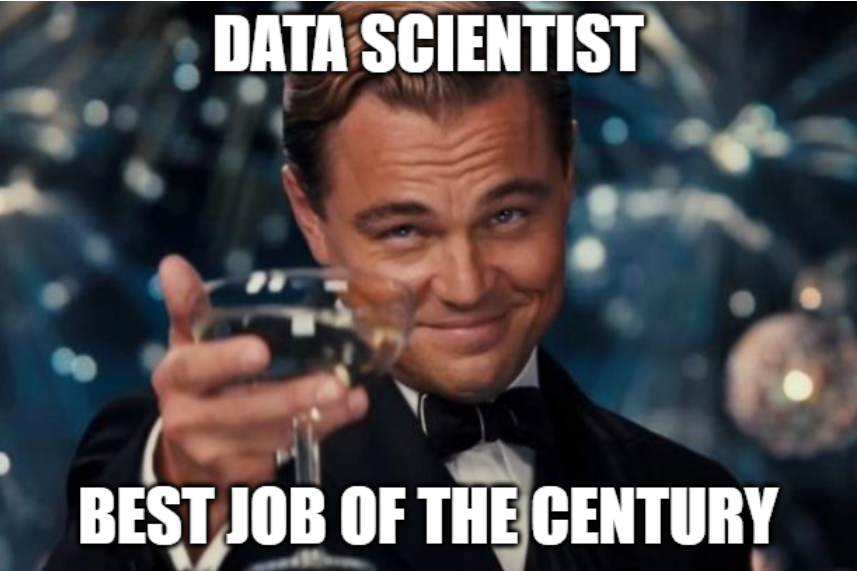